In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d5-cbi-100/__huggingface_repos__.json
/kaggle/input/d5-cbi-100/checkpoint/joint_epoch_100.pth
/kaggle/input/d5-cbi-100/checkpoint/joint_epoch_50.pth
/kaggle/input/d5-cbi-100/checkpoint/visualizations/epoch_50.png
/kaggle/input/d5-cbi-100/checkpoint/visualizations/epoch_100.png
/kaggle/input/prompts/prompts_10.txt
/kaggle/input/prompts/prompts_1000.txt
/kaggle/input/prompt-dataset/D5_task_prompt.json
/kaggle/input/prompt-dataset/D3_tasks_prompt (1).json


In [17]:
from sklearn.manifold import TSNE
import torch
import json
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

filepath= '/kaggle/input/prompt-dataset/D5_task_prompt.json'

with open(filepath) as f:
    data = json.load(f)

    lol = data['lol']
    rain = data['rain']
    blur = data['blur']
    haze = data['haze']
    noise = data['noise']

In [30]:
from sklearn.manifold import TSNE
import torch
import json
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

filepath= '/kaggle/input/prompt-dataset/D5_task_prompt.json'

with open(filepath) as f:
    data = json.load(f)

    lol = data['lol']
    rain = data['rain']
    blur = data['blur']
    haze = data['haze']
    noise = data['noise']

POOL_MODELS = {"sentence-transformers/all-MiniLM-L6-v2", "TaylorAI/bge-micro-v2"}
LMODEL = 'TaylorAI/bge-micro-v2'

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class LanguageModel(nn.Module):
    def __init__(self, model='TaylorAI/bge-micro-v2'):
        super(LanguageModel, self).__init__()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model).to(device)
        self.model_name = model
        # Remove the CLIP vision tower
        if "clip" in self.model_name:
            self.model.vision_model = None
            
        # Freeze the pre-trained parameters (very important)
        for param in self.model.parameters():
            param.requires_grad = False

        # Make sure to set evaluation mode (also important)
        self.model.eval()

    def forward(self, text_batch):
        inputs = self.tokenizer(text_batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad(): # Ensure no gradients are computed for this forward pass

            if "clip" in self.model_name:
                sentence_embedding = self.model.get_text_features(**inputs)
                return sentence_embedding

            outputs = self.model(**inputs)

        if any(model in self.model_name for model in POOL_MODELS):
            sentence_embeddings = mean_pooling(outputs, inputs['attention_mask'])
            # Normalize embeddings
            sentence_embedding = F.normalize(sentence_embeddings, p=2, dim=1)
        else:
            sentence_embedding = outputs.last_hidden_state[:, 0, :]
        return sentence_embedding
    

class LMHead(nn.Module):
    def __init__(self, embedding_dim=384, hidden_dim=256, num_classes=4):
        super(LMHead, self).__init__()
        
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        #self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embd = self.fc1(x)
        embd = F.normalize(embd, p=2, dim=1)
        deg_pred = self.fc2(embd)
        return embd, deg_pred

checkpoint_file = '/kaggle/input/d5-cbi-100/checkpoint/joint_epoch_100.pth'

language_model = LanguageModel(model=LMODEL).to(device).eval()
lm_head = LMHead(embedding_dim=384, hidden_dim=256, num_classes=5).to(device)

state_dict = torch.load(checkpoint_file, map_location=device)
lm_head.load_state_dict(state_dict['lm_head'], strict=False)

<All keys matched successfully>

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


lol raw outputs shape: torch.Size([239, 384])
rain raw outputs shape: torch.Size([237, 384])
blur raw outputs shape: torch.Size([195, 384])
haze raw outputs shape: torch.Size([223, 384])
noise raw outputs shape: torch.Size([197, 384])
All embeddings stacked shape: (1091, 256)


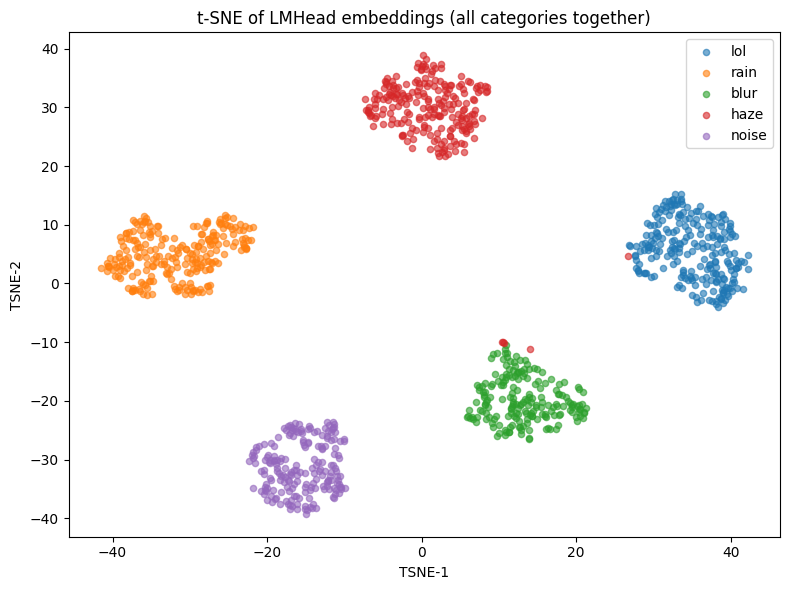

In [31]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# --- 2) Get embeddings for all categories, with shape checks ---
categories = ['lol', 'rain', 'blur', 'haze', 'noise']
cat_data = [lol, rain, blur, haze, noise]  
embs_list = []
labels = []

language_model.eval()
lm_head.eval()

for cat_name, ctgry in zip(categories, cat_data):
    with torch.no_grad():
        outputs = language_model(ctgry)                # (n_sentences, embed_dim)
        print(f"{cat_name} raw outputs shape:", outputs.shape)
        embd, logits = lm_head(outputs)               # embd: (n_sentences, 256) in your code
        embd = embd.detach().cpu().numpy()
    embs_list.append(embd)
    labels.extend([cat_name] * embd.shape[0])

# Stack all embeddings into a single array for t-SNE
all_embs = np.vstack(embs_list)
n_samples = all_embs.shape[0]
print("All embeddings stacked shape:", all_embs.shape)

tsne = TSNE(random_state=42, n_iter=1000, metric='cosine')

emb2d = tsne.fit_transform(all_embs)  # shape (n_samples, 2)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for i, cat_name in enumerate(categories):
    mask = np.array(labels) == cat_name
    ax.scatter(emb2d[mask, 0], emb2d[mask, 1], alpha=0.6, label=cat_name, s=20, marker='o', c=colors[i])

ax.set_title("t-SNE of LMHead embeddings (all categories together)")
ax.legend()
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
plt.tight_layout()
plt.show()


lol raw outputs shape: torch.Size([239, 384])
rain raw outputs shape: torch.Size([237, 384])
blur raw outputs shape: torch.Size([195, 384])
haze raw outputs shape: torch.Size([223, 384])
noise raw outputs shape: torch.Size([197, 384])
All embeddings stacked shape: (1091, 384)


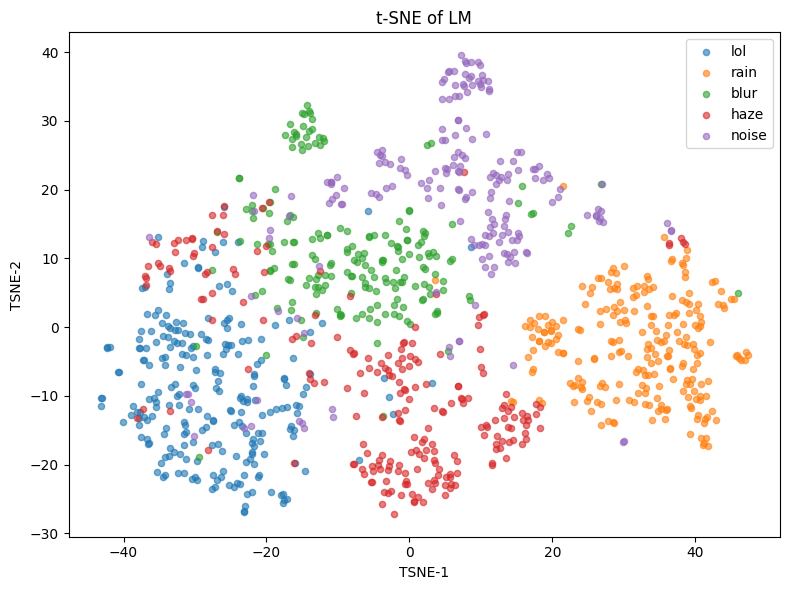

In [32]:
embs_list = []
labels = []

for cat_name, ctgry in zip(categories, cat_data):
    with torch.no_grad():
        outputs = language_model(ctgry)                # (n_sentences, embed_dim)
        print(f"{cat_name} raw outputs shape:", outputs.shape)
        embd = outputs.detach().cpu().numpy()
    embs_list.append(embd)
    labels.extend([cat_name] * embd.shape[0])

# Stack all embeddings into a single array for t-SNE
all_embs = np.vstack(embs_list)
n_samples = all_embs.shape[0]
print("All embeddings stacked shape:", all_embs.shape)

tsne = TSNE(random_state=42, n_iter=1000, metric='cosine')

emb2d = tsne.fit_transform(all_embs)  # shape (n_samples, 2)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for i, cat_name in enumerate(categories):
    mask = np.array(labels) == cat_name
    ax.scatter(emb2d[mask, 0], emb2d[mask, 1], alpha=0.6, label=cat_name, s=20, marker='o', c=colors[i])

ax.set_title("t-SNE of LM")
ax.legend()
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
plt.tight_layout()
plt.show()